#Classificazione di immagini

###Importazione librerie

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import zipfile
import os
import shutil
import pathlib
from pathlib import Path

import matplotlib.image as mpimg
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

###Importazione e preprocessing del dataset



In [ ]:
zip_file_path = '/content/Wonders of World.zip'
extracted_dir_path = '/content/extracted_Wonders_of_World'
os.makedirs(extracted_dir_path, exist_ok=True)

# Estrazione del file zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

print(f"Successfully extracted {zip_file_path} to {extracted_dir_path}")
!ls {extracted_dir_path}

Successfully extracted /content/Wonders of World.zip to /content/extracted_Wonders_of_World
 __MACOSX  'Wonders of World'


In [ ]:
# Categorizzazione immagini
import pathlib
original_base = pathlib.Path("/content/extracted_Wonders_of_World/Wonders of World")
new_base_dir = pathlib.Path("/content")

# Mappa: nome cartella originale → nome categoria nuova
category_map = {
    "/content/extracted_Wonders_of_World/Wonders of World/venezuela_angel_falls": "Venezuela Angel Falls",
    "/content/extracted_Wonders_of_World/Wonders of World/burj_khalifa": "Burj Khalifa",
    "/content/extracted_Wonders_of_World/Wonders of World/chichen_itza": "Chichen Itza",
    "/content/extracted_Wonders_of_World/Wonders of World/christ_the_reedemer": "Christ the Redeemer",
    "/content/extracted_Wonders_of_World/Wonders of World/great_wall_of_china": "Great Wall of China",
    "/content/extracted_Wonders_of_World/Wonders of World/machu_pichu": "Machu Picchu",
    "/content/extracted_Wonders_of_World/Wonders of World/taj_mahal": "Taj Mahal",
    "/content/extracted_Wonders_of_World/Wonders of World/pyramids_of_giza": "Pyramids of Giza",
    "/content/extracted_Wonders_of_World/Wonders of World/stonehenge": " Stonehenge",
    "/content/extracted_Wonders_of_World/Wonders of World/roman_colosseum": "Roman Colosseum",
    "/content/extracted_Wonders_of_World/Wonders of World/eiffel_tower": "Eiffel Tower",
    "/content/extracted_Wonders_of_World/Wonders of World/statue_of_liberty": "Statue of Liberty",


}



In [ ]:
# Check numero di immagini

total_images = 0

print("Conteggio immagini per categoria:\n")

for original_path_str, label in category_map.items():
    folder_path = Path(original_path_str)
    if folder_path.exists():
        num_images = len([f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"{label}: {num_images} immagini")
        total_images += num_images
    else:
        print(f"{label}:  percorso non trovato ({folder_path})")

print(f"\n Totale immagini nel dataset: {total_images}")



Conteggio immagini per categoria:

Venezuela Angel Falls: 251 immagini
Burj Khalifa: 390 immagini
Chichen Itza: 340 immagini
Christ the Redeemer: 323 immagini
Great Wall of China: 392 immagini
Machu Picchu: 393 immagini
Taj Mahal: 158 immagini
Pyramids of Giza: 372 immagini
 Stonehenge: 204 immagini
Roman Colosseum: 394 immagini
Eiffel Tower: 391 immagini
Statue of Liberty: 238 immagini

 Totale immagini nel dataset: 3846


In [ ]:
# Split in train val e test (70,15,15)
def make_subset_proportional(subset_name, split_ratios):

    for orig_folder, new_label in category_map.items():
        source_dir = original_base / orig_folder
        all_images = sorted([f for f in os.listdir(source_dir) if f.lower().endswith(".jpg")])
        n = len(all_images)

        train_end = int(split_ratios["train"] * n)
        val_end = train_end + int(split_ratios["validation"] * n)

        splits = {
            "train": (0, train_end),
            "validation": (train_end, val_end),
            "test": (val_end, n)
        }

        for subset_name, (start, end) in splits.items():
            target_dir = new_base_dir / subset_name / new_label
            os.makedirs(target_dir, exist_ok=True)
            selected_images = all_images[start:end]
            print(f"Copying {len(selected_images)} images from {orig_folder} to {subset_name}/{new_label}")

            for fname in selected_images:
                src = source_dir / fname
                dst = target_dir / fname
                shutil.copyfile(src, dst)

split_ratios = {"train": 0.7, "validation": 0.15, "test": 0.15}
make_subset_proportional("train", split_ratios)



Copying 175 images from /content/extracted_Wonders_of_World/Wonders of World/venezuela_angel_falls to train/Venezuela Angel Falls
Copying 37 images from /content/extracted_Wonders_of_World/Wonders of World/venezuela_angel_falls to validation/Venezuela Angel Falls
Copying 39 images from /content/extracted_Wonders_of_World/Wonders of World/venezuela_angel_falls to test/Venezuela Angel Falls
Copying 273 images from /content/extracted_Wonders_of_World/Wonders of World/burj_khalifa to train/Burj Khalifa
Copying 58 images from /content/extracted_Wonders_of_World/Wonders of World/burj_khalifa to validation/Burj Khalifa
Copying 59 images from /content/extracted_Wonders_of_World/Wonders of World/burj_khalifa to test/Burj Khalifa
Copying 237 images from /content/extracted_Wonders_of_World/Wonders of World/chichen_itza to train/Chichen Itza
Copying 51 images from /content/extracted_Wonders_of_World/Wonders of World/chichen_itza to validation/Chichen Itza
Copying 52 images from /content/extracted_

In [ ]:
subset_base_dir = Path("/content")

for subset_name in ["train", "validation", "test"]:
    print(f"\n📁 {subset_name.upper()}:")

    subset_path = subset_base_dir / subset_name
    if subset_path.exists():
        for category_dir in sorted(subset_path.iterdir()):
            if category_dir.is_dir():
                count = len([f for f in os.listdir(category_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
                print(f"  {category_dir.name}: {count} immagini")
    else:
        print("  ❌ Directory non trovata.")



📁 TRAIN:
   Stonehenge: 142 immagini
  Burj Khalifa: 273 immagini
  Chichen Itza: 237 immagini
  Christ the Redeemer: 226 immagini
  Eiffel Tower: 273 immagini
  Great Wall of China: 274 immagini
  Machu Picchu: 275 immagini
  Pyramids of Giza: 260 immagini
  Roman Colosseum: 275 immagini
  Statue of Liberty: 166 immagini
  Taj Mahal: 110 immagini
  Venezuela Angel Falls: 175 immagini

📁 VALIDATION:
   Stonehenge: 30 immagini
  Burj Khalifa: 58 immagini
  Chichen Itza: 51 immagini
  Christ the Redeemer: 48 immagini
  Eiffel Tower: 58 immagini
  Great Wall of China: 58 immagini
  Machu Picchu: 58 immagini
  Pyramids of Giza: 55 immagini
  Roman Colosseum: 59 immagini
  Statue of Liberty: 35 immagini
  Taj Mahal: 23 immagini
  Venezuela Angel Falls: 37 immagini

📁 TEST:
   Stonehenge: 32 immagini
  Burj Khalifa: 59 immagini
  Chichen Itza: 52 immagini
  Christ the Redeemer: 49 immagini
  Eiffel Tower: 60 immagini
  Great Wall of China: 60 immagini
  Machu Picchu: 60 immagini
  Pyramids 

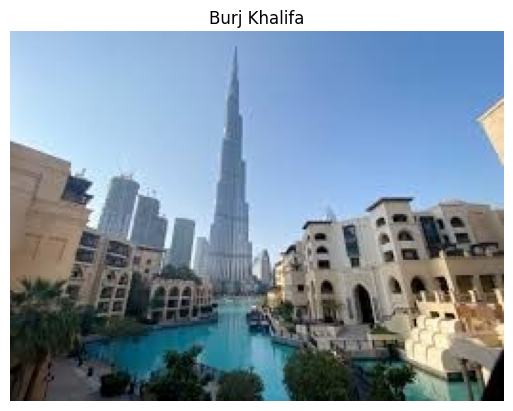

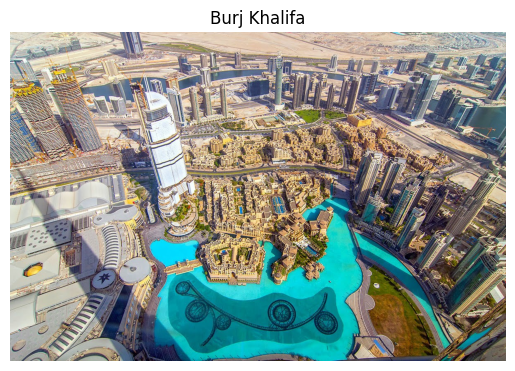

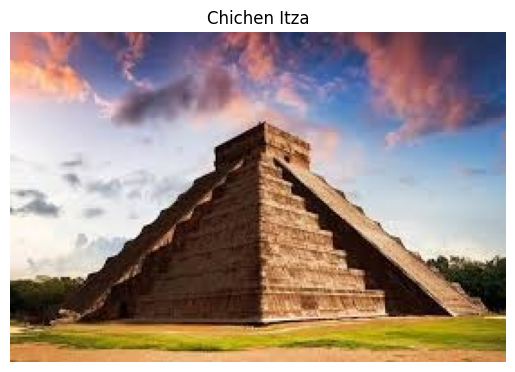

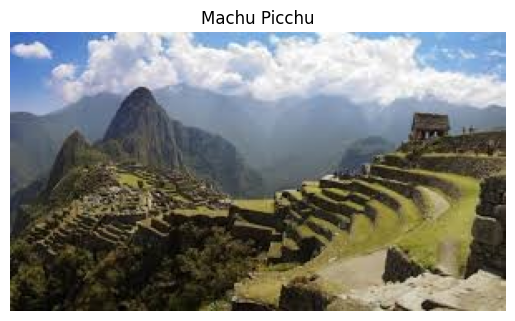

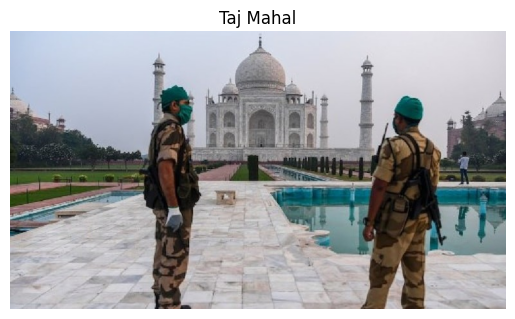

In [ ]:
# Visualizziamo le immagini del dataset

subset_base_dir = Path("/content")

def show_sample_images(subset='train', category=None, num_images=5):
    subset_path = subset_base_dir / subset

    if category:
        image_paths = list((subset_path / category).glob("*.jpg"))
    else:
        image_paths = []
        for category_dir in subset_path.iterdir():
            if category_dir.is_dir():
                image_paths.extend(category_dir.glob("*.jpg"))
        image_paths = list(image_paths)

    if len(image_paths) == 0:
        print("Nessuna immagine trovata.")
        return

    samples = random.sample(image_paths, min(num_images, len(image_paths)))

    for img_path in samples:
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(img_path.parent.name)
        plt.show()
show_sample_images(subset="validation", num_images=5)



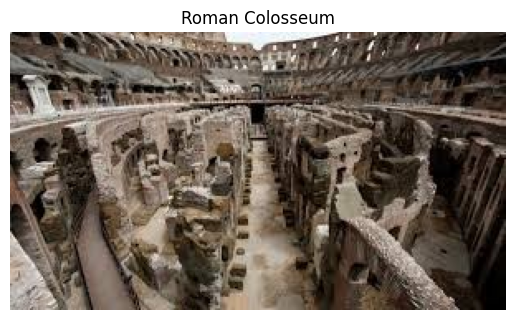

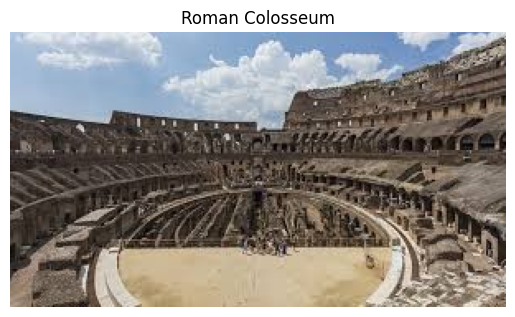

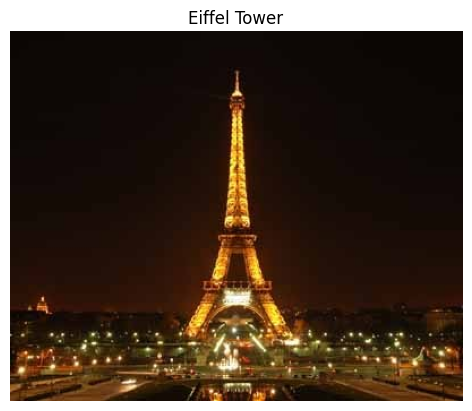

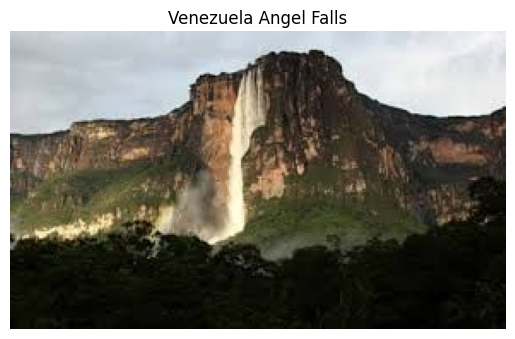

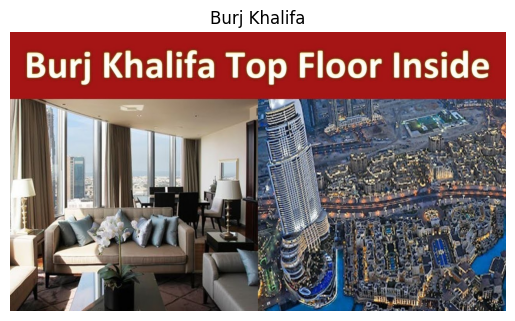

In [ ]:
show_sample_images(subset="train",  num_images=5)

In [ ]:
# 1. Carica i dataset da cartelle
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/train",
    label_mode="int",
    image_size=(224, 224),   # o la dimensione che ti serve
    batch_size=32,
    shuffle=True,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/test",
    label_mode="int",
    image_size=(224, 224),
    batch_size=32,
    shuffle=False,
)

# 2. Funzione per convertire dataset in numpy arrays
def dataset_to_numpy(ds):
    images = []
    labels = []
    for x_batch, y_batch in ds:
        images.append(x_batch.numpy())
        labels.append(y_batch.numpy())
    return np.concatenate(images), np.concatenate(labels)

# 3. Conversione
X_train, y_train = dataset_to_numpy(train_ds)
X_test, y_test = dataset_to_numpy(test_ds)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


Found 2686 files belonging to 12 classes.
Found 590 files belonging to 12 classes.
(2686, 224, 224, 3) (2686,)
(590, 224, 224, 3) (590,)


In [ ]:
# Normalizzazione dei pixel
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Codifica one-hot delle etichette
y_train = to_categorical(y_train, 12)
y_test = to_categorical(y_test, 12)

###Costruzione del modello


In [ ]:
model = Sequential()

# Primo strato convolutivo e di pooling
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))

# Secondo strato convolutivo e di pooling
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Strato Flatten
model.add(Flatten())

# Strato denso
model.add(Dense(64, activation='relu'))

# Dropout dopo il denso
model.add(Dropout(0.3))

# Strato di output
model.add(Dense(12, activation='softmax'))

# Visualizzazione dell'architettura del modello
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    11,944,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,964,172 (45.64 MB)

 Trainable params: 11,964,172 (45.64 MB)

 Non-trainable params: 0 (0.00 B)

###Addestramento - Tentativo 1


In [ ]:
# Compilazione del modello
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Addestramento del modello
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 22s 340ms/step - accuracy: 0.1007 - loss: 5.4644 - val_accuracy: 0.2966 - val_loss: 2.1793
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 24s 82ms/step - accuracy: 0.2947 - loss: 2.0881 - val_accuracy: 0.4068 - val_loss: 1.7760
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.4156 - loss: 1.7398 - val_accuracy: 0.5102 - val_loss: 1.5758
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.5285 - loss: 1.4162 - val_accuracy: 0.5898 - val_loss: 1.3481
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.6469 - loss: 1.0850 - val_accuracy: 0.6712 - val_loss: 1.0800
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.7530 - loss: 0.7683 - val_accuracy: 0.7186 - val_loss: 0.9937
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.8149 - loss: 0.5601 - val_accuracy: 0.7288 - val_loss: 0.9578
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.8579 - loss: 0.4360 - val_accuracy: 0.7475 

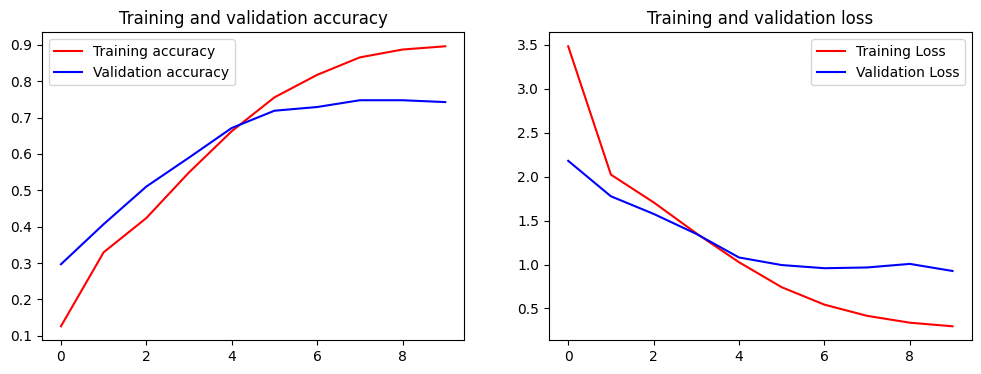

In [ ]:
# Grafico Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)

# Grafico Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

Osservazioni:

* Il modello sta imparando bene (accuracy training in crescita)
* Non c'è overfitting grave, (validation accuracy segue il trend, è stabile)
* La loss sta diminuendo su entrambi i set
* Intorno all'epoca 4-5 la validation loss smette di migliorare significativamente. Questo è il punto ottimale dove fermare il training.

###Tentativo 2

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

# Primo strato convolutivo e di pooling
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))

# Secondo strato convolutivo e di pooling
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Strato Flatten
model.add(Flatten())

# Strato denso
model.add(Dense(64, activation='relu'))

# Dropout dopo il denso
model.add(Dropout(0.6))

# Strato di output
model.add(Dense(12, activation='softmax'))

# Visualizzazione dell'architettura del modello
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │    11,944,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,964,172 (45.64 MB)

 Trainable params: 11,964,172 (45.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

# Compilazione del modello
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Addestramento del modello
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - accuracy: 0.1014 - loss: 3.7634 - val_accuracy: 0.2000 - val_loss: 2.4045
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.1445 - loss: 2.3902 - val_accuracy: 0.2305 - val_loss: 2.3321
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.1488 - loss: 2.3865 - val_accuracy: 0.2593 - val_loss: 2.2274
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.1829 - loss: 2.3184 - val_accuracy: 0.2525 - val_loss: 2.2975
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.1816 - loss: 2.2907 - val_accuracy: 0.2847 - val_loss: 2.1852
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.1740 - loss: 2.2679 - val_accuracy: 0.3085 - val_loss: 2.1254
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.1988 - loss: 2.1872 - val_accuracy: 0.3271 - val_loss: 2.0471
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.1948 - loss: 2.1231 - val_accuracy: 0.3712 - 

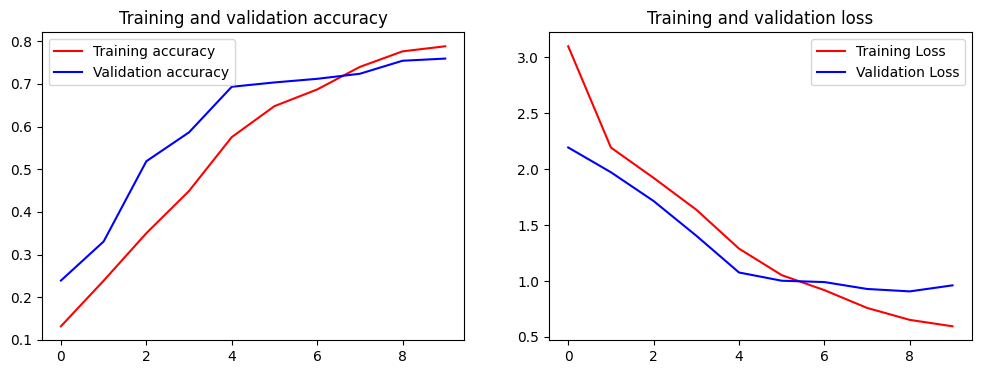

In [ ]:
import matplotlib.pyplot as plt
# Grafico Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)

# Grafico Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

#è leggermente in overfitting però è sempre stabile

CONCLUSIONE:

Il tentativo 1 presenta un overfitting evidente ma costante: validation loss e accuracy si stabilizzano mentre il training continua a migliorare.

Il tentativo 2 è già più stabile, anche se il training è un po’ meno accurato. La validation accuracy è più alta e la curva continua a salire leggermente, il che è positivo.


**Possiamo dire di aver ridotto l’overfitting e migliorato la generalizzazione.**